In [1]:
from scipy.io.wavfile import read, write
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple
import pandas as pd
import os

In [2]:
N_BITS = 2  # Number of bits for quantization

In [3]:
rate, data = read("data/data.wav")
data = data.astype(np.int16)

print(f"Częstotliwosc próbkowania: {rate} Hz")
print(f"Liczba próbek sygnału: {len(data)}")

Częstotliwosc próbkowania: 11025 Hz
Liczba próbek sygnału: 270113


In [4]:
def get_autocorr_coeff(data: np.ndarray, max_lag: int = 10) -> List:
    data_pd = pd.Series(data)
    autocorr_coeffs = []
    
    for i in range(max_lag+1):
        autocorr_coeffs.append(data_pd.autocorr(i).item())

    return autocorr_coeffs

# def get_autocorr_coeff(data: np.ndarray, max_lag: int = 10) -> List:
#     p_list = []
#     p_list.append(np.mean(data*data))   # Add p_0

#     for i in range(1, max_lag+1):
#         p_list.append(np.mean(data[i:]*data[:-i]))

#     return p_list

In [5]:
# Removes empty coefficients added in calculate_levinson_durbin to keep indexing from 1
def clean_coeff_list(coeff_list: List) -> List:
    del coeff_list[0]
    return [coeffs[1:] for coeffs in coeff_list]

# Pads signal with zeros at beginning and end
def pad_signal(data: np.ndarray, padding: int) -> np.ndarray:
    return np.pad(data, (padding, padding), 'constant', constant_values=(0, 0))

# Given reflection coefficients returns True if AR model is stable
def check_stability(refl_coeffs: List) -> bool:
    for refl_coeff in refl_coeffs:
        if np.abs(refl_coeff) >= 1:
            return False
    return True

def calculate_levinson_durbin(data: np.ndarray, r_max: int = 10) -> Tuple:
    p_list = get_autocorr_coeff(data, r_max)

    sigmas = []
    sigmas.append(p_list[0])    # Add sigma_0

    a_list = [[0] for _ in range(0, r_max+1)]   # Adding 0 to every list to start indexing from 1 possible later
    k_list = []     # Reflection coefficients
    for i in range(1, r_max+1):
        p_i = p_list[i]

        z = 0   # Sum from j=1 to i-1 a_j,i-1(N)*p(i-j)(N)

        for j in range(1, i):
            z += a_list[i-1][j]*p_list[i-j]
        ki = (p_i - z) / sigmas[i-1]
        k_list.append(ki)

        for j in range(1, i+1):
            if j == i:
                a_list[i].append(ki)
            else:
                a_list[i].append(a_list[i-1][j]-ki*a_list[i-1][i-j])

        sigma = (1-ki**2)*sigmas[i-1]
        sigmas.append(sigma)

    a_list = clean_coeff_list(a_list)
    return a_list, k_list



def quantize_to_levels(arr, levels):
    flat = arr.ravel()
    idx = np.abs(flat[:, None] - levels[None, :]).argmin(axis=1)
    return levels[idx].reshape(arr.shape)


def quantize_n_bit(arr, n, max_val):
    n_unique_values = 2**n

    # Generate quantization levels between -max_val and max_val
    uniq_vals = np.linspace(-max_val, max_val, n_unique_values)

    # Quantize the array to the nearest levels
    arr_quant = quantize_to_levels(arr, uniq_vals)

    # Create mapping from value to index
    value_to_index = {v: i for i, v in enumerate(uniq_vals)}

    # Vectorized mapping using list comprehension
    indices = np.array([value_to_index[val] for val in arr_quant])

    
    return arr_quant, indices

In [6]:
class ARModel:
    def __init__(self, order: int = 4) -> None:
        self.order = order
        self.theta = np.zeros((order,1), dtype=np.float64)

    def set_coeffs(self, coeffs: np.ndarray) -> None:
        self.theta = coeffs

    def _predict(self, x: np.ndarray) -> float:
        return float(self.theta.T @ x)

# Nadajnik

In [7]:
class Transmitter:
    def __init__(self, ar_order: int = 10, segment_width: int = 256, overlap: int = 10) -> None:
        self.segment_width = segment_width
        self.overlap = overlap
        self.ar_model = ARModel(order=ar_order)

    def forward(self, data: np.ndarray) -> Tuple:
        segmented_data = self._prepare_data(data)

        errors_list = []
        coeffs_list = []
        targets_list = []
        predictions_list = []
        for segment in segmented_data:
            ar_model_coeffs, refl_coeffs = calculate_levinson_durbin(pad_signal(self._flatten_segment_ends(segment), self.ar_model.order))
            ar_model_coeffs = ar_model_coeffs[-1]
            self.ar_model.set_coeffs(np.flip(np.array(ar_model_coeffs, dtype=np.float32)))
            
            targets = []
            predictions = []
            segment_errors = []
            for i in range(self.ar_model.order, len(segment)):
                curr_data = segment[i-self.ar_model.order:i]
                prediction = self.ar_model._predict(curr_data)
                target = segment[i]
                error = target - prediction
                segment_errors.append(error)
                predictions.append(prediction)
                targets.append(target)
            
            errors_list.append(segment_errors)
            coeffs_list.append(ar_model_coeffs)
            predictions_list.append(predictions)
            targets_list.append(targets)

        errors_list = np.array(errors_list)
        coeffs_list = np.array(coeffs_list)
        predictions_list = np.array(predictions_list)
        targets_list = np.array(targets_list)

        return coeffs_list, errors_list, refl_coeffs

    # Given data cuts it into segments with specified overlap
    def _prepare_data(self, data: np.ndarray) -> np.ndarray:
        n_segments = len(data) // (self.segment_width - self.overlap)

        segments = []
        for i in range(n_segments):
            start_index = i*self.segment_width-i*self.overlap
            end_index = start_index+self.segment_width
            segment = data[start_index:end_index]

            # Drop last segment if it's length is not equal to segment width
            if i == n_segments-1 and len(segment) != self.segment_width:
                break

            segments.append(segment)

        return np.array(segments)
    
    def _flatten_segment_ends(self, segment: np.ndarray) -> np.ndarray:
        cos_arg = (2*np.pi / (len(segment)+1))*np.arange(1, len(segment)+1)
        return 0.5*(1 - np.cos(cos_arg))*segment

In [8]:
transmitter = Transmitter()

In [9]:
coeffs, errors, refl_coeffs = transmitter.forward(data)

### Sprawdzenie stabilności

In [10]:
check_stability(refl_coeffs)

True

# Kwantyzacja

In [11]:
def pack_bits(bit_string):
    # Pad the string so length is multiple of 8
    length = len(bit_string)
    padded_length = ((length + 7) // 8) * 8  # next multiple of 8
    bit_string = bit_string.rjust(padded_length, '0')

    packed_bytes = bytearray()
    for i in range(0, padded_length, 8):
        byte = bit_string[i:i+8]
        packed_bytes.append(int(byte, 2))
    return packed_bytes

def unpack_bits(packed_bytes):
    bits = ''.join(f'{byte:08b}' for byte in packed_bytes)
    return bits


In [12]:
quantized_errors = []
indices = []
max_vals = []

for segment_errors in errors:
    max_val = np.abs(segment_errors).max()
    quantized_segment_errors, idx = quantize_n_bit(segment_errors, N_BITS, max_val)
    quantized_errors.append(quantized_segment_errors)
    indices.append(idx)
    max_vals.append(max_val)

quantized_errors = np.array(quantized_errors)
indices = np.array(indices)
max_vals = np.array(max_vals)

In [13]:
all_bits = ""
for segment_idx in indices:
    segment_bits = ""
    for value in segment_idx:
        segment_bits += format(value, f'0{N_BITS}b')
    all_bits += segment_bits

### Zapis danych

In [14]:
os.makedirs("results", exist_ok=True)

In [15]:
packed = pack_bits(all_bits)
with open('results/binary_packed.bin', 'wb') as f:
    f.write(packed)

In [16]:
np.save("results/max_vals.npy", max_vals)
np.save("results/coeffs.npy", coeffs)

### Odczyt danych

In [17]:
with open('results/binary_packed.bin', 'rb') as f:
    binary_data = f.read()

restored_str = unpack_bits(binary_data)
padding_size = len(restored_str) - (len(restored_str) // 246)*246
restored_str = restored_str[padding_size:]

# Split by segments
converted_idx = [restored_str[i:i+246*N_BITS] for i in range(0, len(restored_str), 246*N_BITS)]

# Convert bit strings back to integers (level indices)
for i in range(len(converted_idx)):
    converted_idx[i] = [int(converted_idx[i][j*N_BITS:(j+1)*N_BITS], N_BITS) for j in range(len(converted_idx[i])//N_BITS)]

converted_idx = np.array(converted_idx)

In [18]:
loaded_max_vals = np.load("results/max_vals.npy")
loaded_coeffs = np.load("results/coeffs.npy")

# Odbiornik

In [19]:
class Receiver:
    def __init__(self, ar_order: int = 10, segment_width: int = 256, overlap: int = 10):
        self.segment_width = segment_width
        self.overlap = overlap
        self.ar_model = ARModel(order=ar_order)

    def forward(self, errors_indices: np.ndarray, max_vals: np.ndarray, coeffs: np.ndarray, init_data: np.ndarray, n_bits: int = 2):
        reconstructed_data = []
        reconstructed_data.extend(init_data.tolist())    # Add initial data to the beginning

        for i, (segment_errors_idx, ar_model_coeffs) in enumerate(zip(errors_indices, coeffs)):    
            segment_max_val = max_vals[i]
            segment_errors = self._indices_to_errors(segment_errors_idx, segment_max_val, n_bits=n_bits)

            # Set AR model coefficients for current segment
            self.ar_model.set_coeffs(np.flip(np.array(ar_model_coeffs, dtype=np.float32)))

            for j in range(len(segment_errors)):
                curr_data = np.array(reconstructed_data[-self.ar_model.order:], dtype=np.float32)
                prediction = self.ar_model._predict(curr_data)
                reconstructed_value = prediction + segment_errors[j]
                reconstructed_data.append(reconstructed_value)

        return np.array(reconstructed_data)
    
    def _indices_to_errors(self, errors_indices: np.ndarray, max_val: float, n_bits: int) -> np.ndarray:
        n_unique_values = 2**n_bits
        uniq_vals = np.linspace(-max_val, max_val, n_unique_values)

        index_to_value = {i: v for i, v in enumerate(uniq_vals)}

        # Vectorized mapping using list comprehension
        errors = np.array([index_to_value[idx] for idx in errors_indices])

        return errors

In [20]:
receiver = Receiver()

In [21]:
reconstructed_data = receiver.forward(converted_idx, loaded_max_vals, loaded_coeffs, init_data=data[:10])

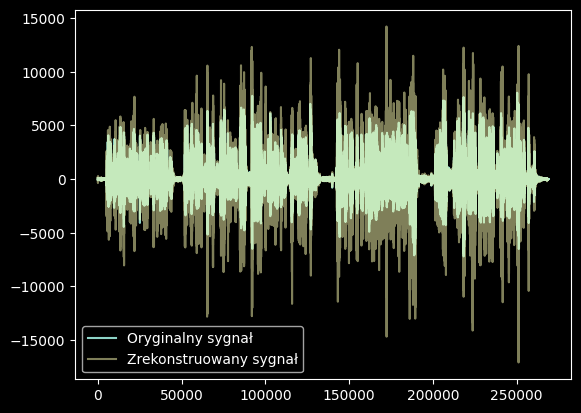

In [22]:
start_index = 1000
end_index = -1

plt.plot(data[start_index:end_index], label="Oryginalny sygnał")
plt.plot(reconstructed_data[start_index:end_index], label="Zrekonstruowany sygnał", alpha=0.5)
plt.legend()
plt.show()

In [23]:
write("data/reconstructed_data.wav", rate, reconstructed_data.astype(np.int16))